# 導入一些常用的函式

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
from ipywidgets import interact, FloatSlider, IntSlider

In [2]:
%env KERAS_BACKEND=tensorflow
from keras.models import Sequential, Model
from keras.layers import Input, Lambda
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from keras import backend as K

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.


In [3]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

In [4]:
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train / x_train.max()

x_test -= x_test.min()
x_test = x_test / x_test.max()

In [5]:
enc_1 = Dense(100, activation = 'sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation = 'sigmoid')
dec_1 = Dense(784, activation = 'sigmoid')

In [6]:
x = Input(shape = (784, ))

enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

Instructions for updating:
Colocations handled automatically by placer.


# 抽樣

In [7]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape = (2, ), mean = 0., stddev = 1)
    return z_mean + epsilon * K.exp(z_log_var / 2)

In [8]:
z = Lambda(sampling, output_shape=(2, ))([z_mean, z_log_var])

In [9]:
x_hat = dec_1(dec_2((z)))

In [10]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          78500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

# 定義 loss function

In [11]:
def vae_loss(x, x_recon):
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    KL_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1)
    return KL_loss + recovery_loss

In [12]:
VAE.load_weights('VAE_handwriting_model_weights.h5')

In [13]:
VAE_encoder = Model(x, z_mean)
VAE_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [14]:
h_input = Input(shape = (2, ))
VAE_decoder = Model(h_input, dec_1(dec_2((h_input))))
VAE_decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [15]:
indices = np.random.randint(10000, size = 3000)
VAE_latent = VAE_encoder.predict(x_test[indices])
VAE_latent.shape

(3000, 2)

Text(0, 0.5, 'mean_1')

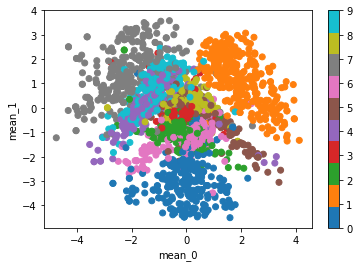

In [16]:
plt.scatter(VAE_latent[:, 0], VAE_latent[:, 1], c = y_test0[indices], cmap = 'tab10')
plt.colorbar()
plt.xlabel('mean_0')
plt.ylabel('mean_1')

In [17]:
num_index = [[] for i in range(0, 10)]
for i in range(0, 60000):
    num_index[y_train0[i]] += [i]
    
idx_1 = 0
idx_2 = 9

# 互動

In [18]:
def inBetween(t, first_number, second_number):
    global idx_1
    global idx_2
    
    if(idx_1 not in num_index[first_number]):
        idx_1 = random.choice(num_index[first_number])
    if(idx_2 not in num_index[second_number]):
        idx_2 = random.choice(num_index[second_number])

    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*data_0 + t*data_1

    mu_0 = VAE_encoder.predict(x_train[idx_1:idx_1 + 1]).squeeze()
    mu_1 = VAE_encoder.predict(x_train[idx_2:idx_2 + 1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1
    
    plt.figure(figsize = (10, 8))
    ax1 = plt.subplot(2, 1, 2)

    ax1.scatter(mu_0[0], mu_0[1], label = 'first number')
    ax1.scatter(mu_1[0], mu_1[1], label = 'second number')
    ax1.scatter(mu_t[0], mu_t[1])
    ax1.annotate(first_number, (mu_0[0], mu_0[1]))
    ax1.annotate(second_number, (mu_1[0], mu_1[1]))
    ax1.annotate('(' + str(mu_t[0]) + ', ' + str(mu_t[1]) + ')', (mu_t[0], mu_t[1]))
    
    ax1.legend()
    ax1.plot([mu_0[0], mu_1[0]], [mu_0[1], mu_1[1]], ls = '--', alpha=0.7)
    
    ax2 = plt.subplot(2, 3, 1)
    ax2.set_title('first number')
    ax2.imshow(data_0, cmap = 'Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.set_title('middle number')
    ax3.imshow(data_t, cmap = 'Greys')

    ax4 = plt.subplot(2, 3, 3)
    ax4.set_title('second number')
    ax4.imshow(data_1, cmap = 'Greys')

In [19]:
interact(inBetween, first_number = IntSlider(value = 0, min = 0, max = 9), t = FloatSlider(value = 0.5, min =0 , max = 1.0,step = 0.025), second_number = IntSlider(value = 9, min = 0, max = 9))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.025), IntSlider(value=0, descrip…

<function __main__.inBetween(t, first_number, second_number)>

interact的截圖

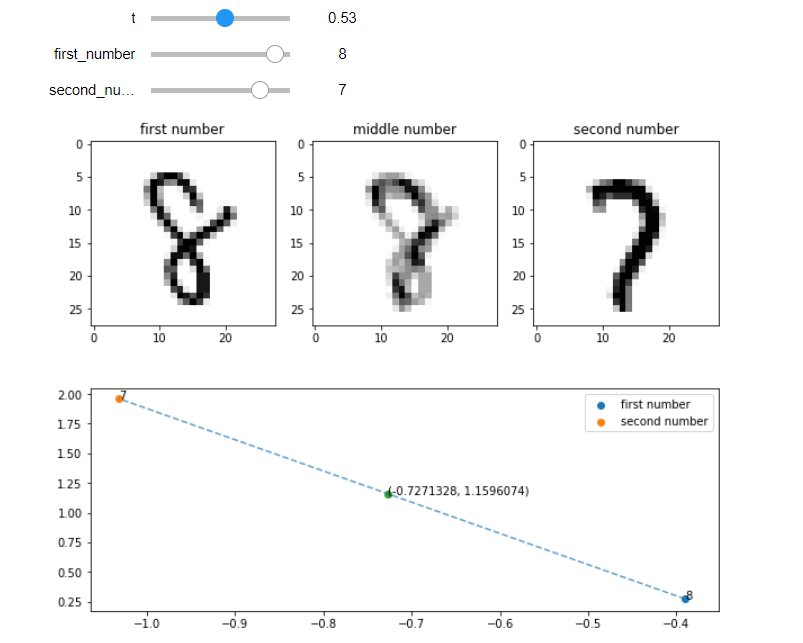